# 3. Formal Concept Analysis

This notebook focuses on Formal Concept Analysis (FCA), which is a method for deriving a concept hierarchy from a collection of objects and their properties.

## Objectives
- Load the frequent itemsets discovered in the previous notebook
- Create a formal context from the frequent itemsets
- Build a concept lattice
- Visualize the concept lattice
- Extract concept hierarchies

## Theoretical Background

**Formal Concept Analysis (FCA)** is a mathematical theory of data analysis that identifies conceptual structures among datasets. The main components are:

1. **Formal Context**: A triple (G, M, I) where G is a set of objects, M is a set of attributes, and I is a binary relation between G and M.

2. **Formal Concept**: A pair (A, B) where A ⊆ G, B ⊆ M, and A is the set of all objects sharing all attributes in B, while B is the set of all attributes shared by all objects in A.

3. **Concept Lattice**: The hierarchical structure formed by all formal concepts of a formal context, ordered by inclusion of extents (or dually, by inclusion of intents).

FCA provides a complementary view to frequent pattern mining by organizing the discovered patterns into a conceptual hierarchy.

## Import Required Libraries

In [4]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from itertools import combinations
from typing import Dict, List, Set, Tuple, Any

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

# Ensure directories exist
os.makedirs('output', exist_ok=True)
os.makedirs('figures', exist_ok=True)

## Helper Functions

In [5]:
def load_json_file(file_path: str) -> Any:
    """Load data from a JSON file."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)


def save_json_file(data: Any, file_path: str) -> None:
    """Save data to a JSON file."""
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data, f, indent=2)


def create_formal_context(itemsets: List[List[str]]) -> pd.DataFrame:
    """Create a formal context from itemsets.

    Args:
        itemsets: List of itemsets (each itemset is a list of items)

    Returns:
        DataFrame representing the formal context
    """
    # Extract all unique items
    all_items = set()
    for itemset in itemsets:
        all_items.update(itemset)
    all_items = sorted(all_items)

    # Create the formal context as a DataFrame
    # Each row is an itemset (concept)
    context = pd.DataFrame(index=range(len(itemsets)), columns=all_items, dtype=bool)
    context.fillna(False, inplace=True)

    # Fill in the context - mark True only for items in each itemset
    for i, itemset in enumerate(itemsets):
        for item in all_items:
            context.loc[i, item] = item in itemset

    return context


def concept_intent(objects: Set[int], context: pd.DataFrame) -> Set[str]:
    """Compute the intent of a set of objects."""
    if not objects:
        return set(context.columns)

    intent = set(context.columns)
    for obj in objects:
        obj_attrs = set(context.columns[context.iloc[obj]])
        intent &= obj_attrs

    return intent


def concept_extent(attributes: Set[str], context: pd.DataFrame) -> Set[int]:
    """Compute the extent of a set of attributes."""
    extent = set(range(len(context)))

    for attr in attributes:
        if attr in context.columns:
            attr_objs = set(context.index[context[attr]])
            extent &= attr_objs

    return extent


def generate_concepts(context: pd.DataFrame) -> List[Tuple[Set[int], Set[str]]]:
    """Generate all formal concepts from a formal context."""
    concepts = []
    all_objects = set(range(len(context)))

    # Start with the top concept (all objects, shared attributes)
    top_intent = concept_intent(all_objects, context)
    top_extent = concept_extent(top_intent, context)
    concepts.append((top_extent, top_intent))

    # Generate concepts for each individual attribute
    for attr in context.columns:
        attr_extent = concept_extent({attr}, context)
        attr_intent = concept_intent(attr_extent, context)
        concept = (attr_extent, attr_intent)

        if concept not in concepts:
            concepts.append(concept)

    # Generate additional concepts by combining attributes
    for k in range(2, len(context.columns)):
        for attrs_combo in combinations(context.columns, k):
            attrs_set = set(attrs_combo)
            extent = concept_extent(attrs_set, context)
            intent = concept_intent(extent, context)
            concept = (extent, intent)

            if concept not in concepts:
                concepts.append(concept)

    # Sort concepts by extent size (descending)
    concepts.sort(key=lambda c: (len(c[0]), -len(c[1])), reverse=True)

    return concepts


def build_concept_lattice(concepts: List[Tuple[Set[int], Set[str]]]) -> nx.DiGraph:
    """Build a concept lattice (directed graph) from concepts."""
    lattice = nx.DiGraph()

    # Add nodes to the lattice
    for i, (extent, intent) in enumerate(concepts):
        # Create a label for the concept
        if len(intent) <= 3:
            label = ', '.join(sorted(intent))
        else:
            label = f"{len(extent)} obj, {len(intent)} attr"

        lattice.add_node(i, extent=extent, intent=intent, label=label,
                         ext_size=len(extent), int_size=len(intent))

    # Add edges representing the subconcept relation
    for i, (extent_i, _) in enumerate(concepts):
        for j, (extent_j, _) in enumerate(concepts):
            if i != j and extent_j.issubset(extent_i):
                # Check if direct subconcept (no intermediate concepts)
                is_direct = True
                for k, (extent_k, _) in enumerate(concepts):
                    if (i != k and j != k and
                        extent_j.issubset(extent_k) and
                        extent_k.issubset(extent_i)):
                        is_direct = False
                        break

                if is_direct:
                    lattice.add_edge(i, j)

    return lattice

## Load Frequent Itemsets

We'll load the frequent itemsets discovered in the previous notebook:

In [6]:
# Load configuration
import os

# Get the correct paths
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    project_dir = os.path.dirname(current_dir)
else:
    project_dir = current_dir

config_path = os.path.join(project_dir, 'config.json')
try:
    config = load_json_file(config_path)
    min_support = config.get('min_support', 0.2)
except (FileNotFoundError, json.JSONDecodeError):
    print("Config file not found or invalid. Using default parameters.")
    min_support = 0.2

# Try to load FP-Growth itemsets first (usually more efficient)
try:
    fpgrowth_itemsets_path = os.path.join(project_dir, 'output', 'fpgrowth_itemsets.csv')
    fpgrowth_itemsets_df = pd.read_csv(fpgrowth_itemsets_path)
    print(f"Loaded {len(fpgrowth_itemsets_df)} frequent itemsets from FP-Growth results")

    # Convert string representation of lists to actual lists
    itemsets = []
    for _, row in fpgrowth_itemsets_df.iterrows():
        # Handle different string formats of lists
        itemset_str = row['itemsets']
        if isinstance(itemset_str, str):
            # Remove brackets, quotes, and split by commas
            itemset_str = itemset_str.strip('[]').replace("'", "").replace('"', '')
            if itemset_str:
                items = [item.strip() for item in itemset_str.split(',')]
                itemsets.append(items)
            else:
                # Handle empty itemsets (should be rare in frequent itemsets)
                itemsets.append([])

except FileNotFoundError:
    # If FP-Growth results not found, try Apriori
    try:
        apriori_itemsets_path = os.path.join(project_dir, 'output', 'apriori_itemsets.csv')
        apriori_itemsets_df = pd.read_csv(apriori_itemsets_path)
        print(f"Loaded {len(apriori_itemsets_df)} frequent itemsets from Apriori results")

        # Convert string representation of lists to actual lists
        itemsets = []
        for _, row in apriori_itemsets_df.iterrows():
            # Handle different string formats of lists
            itemset_str = row['itemsets']
            if isinstance(itemset_str, str):
                # Remove brackets, quotes, and split by commas
                itemset_str = itemset_str.strip('[]').replace("'", "").replace('"', '')
                if itemset_str:
                    items = [item.strip() for item in itemset_str.split(',')]
                    itemsets.append(items)
                else:
                    # Handle empty itemsets (should be rare in frequent itemsets)
                    itemsets.append([])
    except FileNotFoundError:
        # If no itemsets found, create sample data
        print("No itemset files found. Run the mining notebook first to generate itemsets!")
        print("Creating sample itemsets for demo purposes...")
        itemsets = [
            ["apple"],
            ["milk"],
            ["bread"],
            ["apple", "milk"],
            ["milk", "bread"],
            ["apple", "bread"],
            ["apple", "milk", "bread"]
        ]

# Debug - print first few itemsets to check format
print("First few itemsets loaded:")
for i, itemset in enumerate(itemsets[:5]):
    print(f"Itemset {i+1}: {itemset}")

# Filter itemsets by size if needed
min_size = 1  # Minimum number of items in an itemset
max_size = 10  # Maximum number of items in an itemset
filtered_itemsets = [itemset for itemset in itemsets if min_size <= len(itemset) <= max_size]

print(f"Using {len(filtered_itemsets)} itemsets for concept analysis")

# Display some sample itemsets
print("\nSample itemsets:")
for itemset in filtered_itemsets[:5]:
    print(itemset)

Loaded 5 frequent itemsets from FP-Growth results
First few itemsets loaded:
Itemset 1: ['milk']
Itemset 2: ['bread']
Itemset 3: ['rice']
Itemset 4: ['cheese']
Itemset 5: ['banana']
Using 5 itemsets for concept analysis

Sample itemsets:
['milk']
['bread']
['rice']
['cheese']
['banana']


## Create Formal Context

Now, we'll create a formal context from the frequent itemsets:

In [7]:
# Create formal context
context = create_formal_context(filtered_itemsets)

print(f"Created formal context with shape: {context.shape}")
print(f"Objects (rows): {context.shape[0]}")
print(f"Attributes (columns): {context.shape[1]}")

# Display the formal context
print("\nFormal Context (sample):")
display(context.head())

# Save the context to CSV
context_path = 'output/formal_context.csv'
context.to_csv(context_path, index=False)
print(f"Saved formal context to {context_path}")

Created formal context with shape: (5, 5)
Objects (rows): 5
Attributes (columns): 5

Formal Context (sample):


,banana,bread,cheese,milk,rice
0,False,False,False,True,False
1,False,True,False,False,False
2,False,False,False,False,True
3,False,False,True,False,False
4,True,False,False,False,False


Saved formal context to output/formal_context.csv


## Generate Formal Concepts

Now, let's generate all formal concepts from the context:

In [8]:
# Generate concepts
concepts = generate_concepts(context)

print(f"Generated {len(concepts)} formal concepts")

# Display some sample concepts
print("\nSample Concepts (Extent, Intent):")
for extent, intent in concepts[:5]:
    print(f"Extent: {sorted(extent)} | Intent: {sorted(intent)}")

# Save concepts to JSON with correct path
concepts_json = [
    {
        "extent": sorted(list(extent)),
        "intent": sorted(list(intent))
    }
    for extent, intent in concepts
]

concepts_path = os.path.join(project_dir, 'output', 'formal_concepts.json')
save_json_file(concepts_json, concepts_path)
print(f"Saved {len(concepts)} formal concepts to {concepts_path}")

Generated 7 formal concepts

Sample Concepts (Extent, Intent):
Extent: [0, 1, 2, 3, 4] | Intent: []
Extent: [4] | Intent: ['banana']
Extent: [1] | Intent: ['bread']
Extent: [3] | Intent: ['cheese']
Extent: [0] | Intent: ['milk']
Saved 7 formal concepts to e:\project-x\output\formal_concepts.json


## Build Concept Lattice

Let's build the concept lattice from the formal concepts:

Built concept lattice with 7 nodes and 10 edges


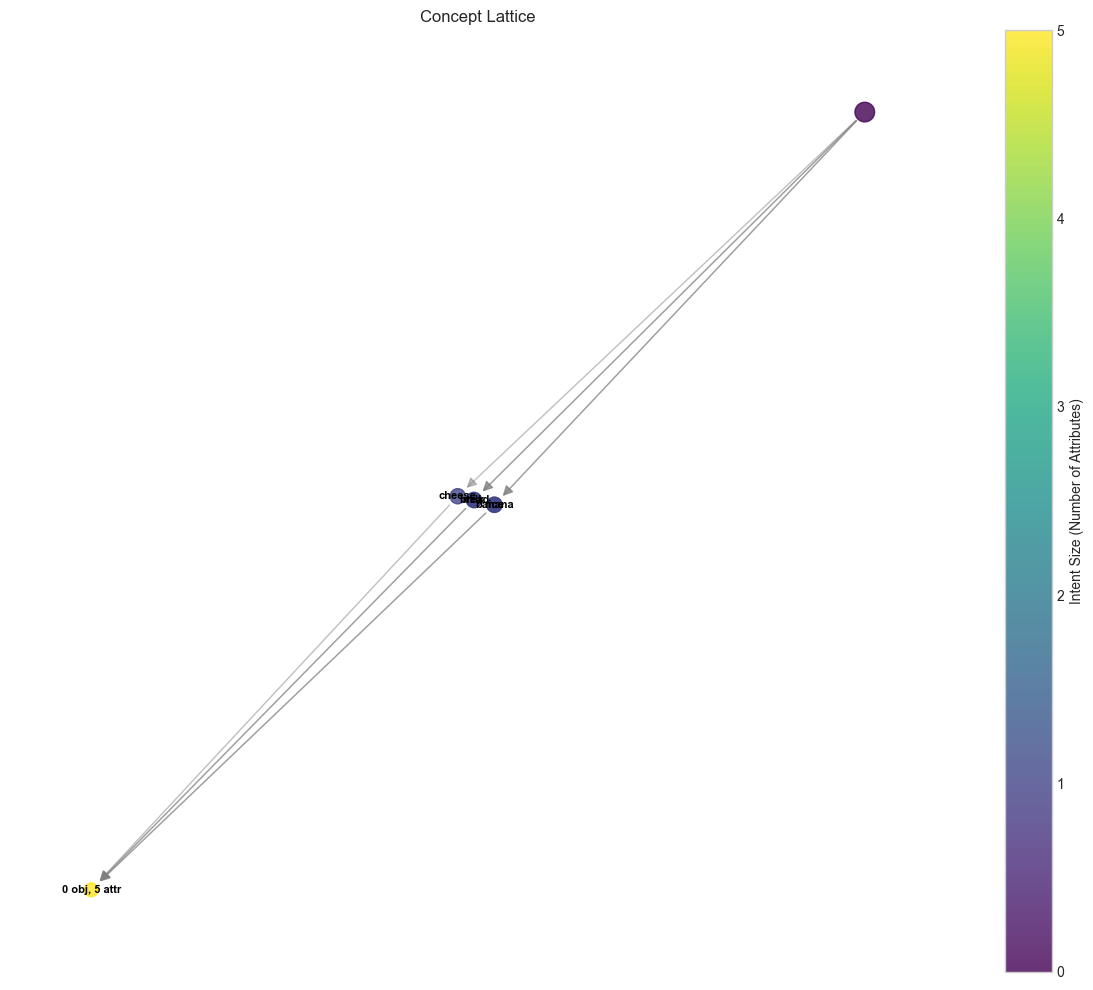

In [10]:
# Build concept lattice first
lattice = build_concept_lattice(concepts)

print(f"Built concept lattice with {lattice.number_of_nodes()} nodes and {lattice.number_of_edges()} edges")

# Visualize concept lattice
plt.figure(figsize=(12, 10))

# Use a hierarchical layout - since graphviz might not be available, use kamada_kawai_layout
pos = nx.kamada_kawai_layout(lattice)

# Node properties
node_sizes = [100 + 20 * lattice.nodes[n]['ext_size'] for n in lattice.nodes]
node_colors = [lattice.nodes[n]['int_size'] for n in lattice.nodes]

# Draw the lattice
nodes = nx.draw_networkx_nodes(
    lattice, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.8
)

edges = nx.draw_networkx_edges(
    lattice, pos,
    width=1.0,
    alpha=0.5,
    edge_color='gray',
    arrows=True,
    arrowsize=15
)

# Add labels
labels = {n: lattice.nodes[n]['label'] for n in lattice.nodes}
nx.draw_networkx_labels(
    lattice, pos,
    labels=labels,
    font_size=8,
    font_weight='bold'
)

# Add colorbar
plt.colorbar(nodes, label='Intent Size (Number of Attributes)')

plt.title('Concept Lattice')
plt.axis('off')

# Save the figure with correct path
plt.tight_layout()
figures_path = os.path.join(project_dir, 'figures', 'concept_lattice.png')
plt.savefig(figures_path, dpi=300)
plt.show()

## Visualize Concept Lattice

Now, let's visualize the concept lattice:

In [11]:
# Get lattice properties (lattice was already built in previous cell)
roots = [n for n, d in lattice.in_degree() if d == 0]
leaves = [n for n, d in lattice.out_degree() if d == 0]

print(f"Number of root concepts: {len(roots)}")
print(f"Number of leaf concepts: {len(leaves)}")

# Check if the lattice is a DAG before calculating longest path
if nx.is_directed_acyclic_graph(lattice):
    print(f"Longest path length: {nx.dag_longest_path_length(lattice)}")
else:
    print("Lattice contains cycles - longest path calculation not applicable")

Number of root concepts: 1
Number of leaf concepts: 1
Longest path length: 2


## Extract Concept Hierarchies

Let's extract and analyze the concept hierarchies:

Extracted 26 concept paths from root to leaf

Sample Concept Paths:
Path 1:
   | Extent: 28 objects | Intent: 0 attributes
  Bread | Extent: 6 objects | Intent: 1 attributes
  Bread, Milk | Extent: 3 objects | Intent: 2 attributes
  Apple, Bread, Milk | Extent: 1 objects | Intent: 3 attributes
  0 obj, 12 attr | Extent: 0 objects | Intent: 12 attributes

Path 2:
   | Extent: 28 objects | Intent: 0 attributes
  Bread | Extent: 6 objects | Intent: 1 attributes
  Bread, Milk | Extent: 3 objects | Intent: 2 attributes
  Bread, Butter, Milk | Extent: 1 objects | Intent: 3 attributes
  0 obj, 12 attr | Extent: 0 objects | Intent: 12 attributes

Path 3:
   | Extent: 28 objects | Intent: 0 attributes
  Bread | Extent: 6 objects | Intent: 1 attributes
  Apple, Bread | Extent: 2 objects | Intent: 2 attributes
  Apple, Bread, Milk | Extent: 1 objects | Intent: 3 attributes
  0 obj, 12 attr | Extent: 0 objects | Intent: 12 attributes



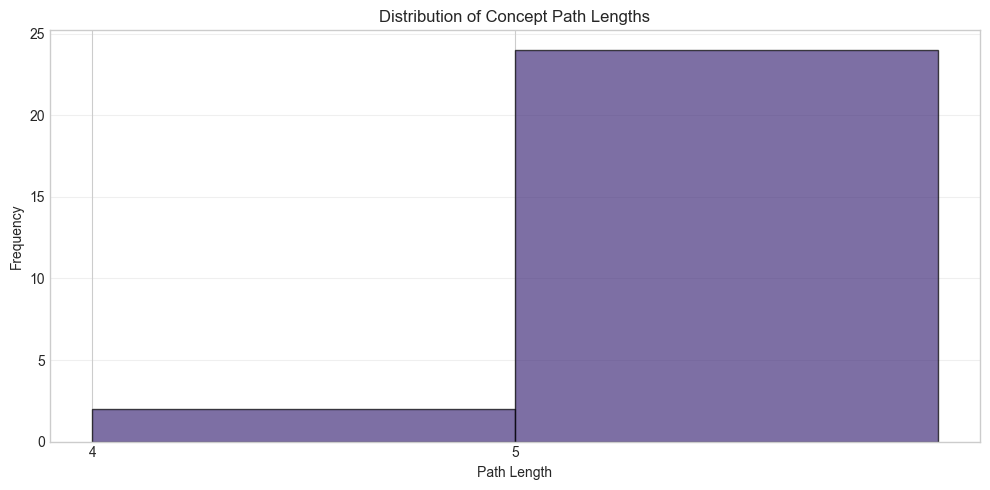

In [ ]:
# Extract concept hierarchies
def extract_paths_from_root(graph, root):
    """Extract all paths from a root node to leaves."""
    paths = []

    def dfs(node, current_path):
        # Add current node to path
        new_path = current_path + [node]

        # If leaf node, add the path to results
        successors = list(graph.successors(node))
        if not successors:
            paths.append(new_path)
        else:
            # Continue DFS for all children
            for succ in successors:
                dfs(succ, new_path)

    dfs(root, [])
    return paths

# Extract paths from roots to leaves
all_paths = []
for root in roots:
    root_paths = extract_paths_from_root(lattice, root)
    all_paths.extend(root_paths)

print(f"Extracted {len(all_paths)} concept paths from root to leaf")

# Display some sample paths
print("\nSample Concept Paths:")
for i, path in enumerate(all_paths[:3]):
    print(f"Path {i+1}:")
    for node in path:
        extent = lattice.nodes[node]['extent']
        intent = lattice.nodes[node]['intent']
        print(f"  {lattice.nodes[node]['label']} | Extent: {len(extent)} objects | Intent: {len(intent)} attributes")
    print()

# Analyze path lengths
path_lengths = [len(path) for path in all_paths]

plt.figure(figsize=(10, 5))
plt.hist(path_lengths, bins=range(min(path_lengths), max(path_lengths) + 2),
         alpha=0.7, edgecolor='black')
plt.title('Distribution of Concept Path Lengths')
plt.xlabel('Path Length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.xticks(range(min(path_lengths), max(path_lengths) + 1))

# Save the figure
plt.tight_layout()
plt.savefig('figures/path_length_distribution.png', dpi=300)
plt.show()

## Analyze Attribute Implications

Let's analyze the implications between attributes based on the concept lattice:

Identified 18 key concepts
Key concept subgraph is not connected. Adding connecting nodes...


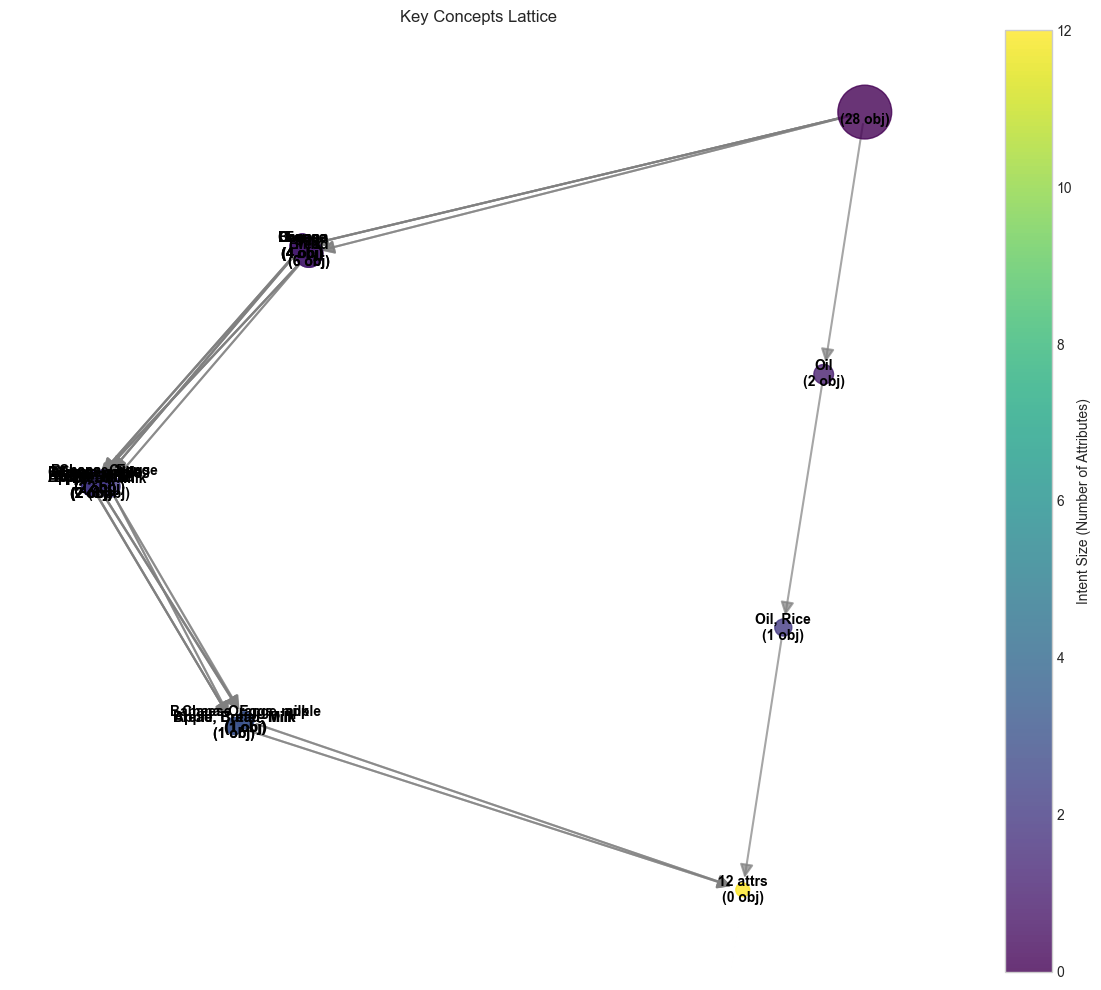

In [ ]:
# Identify key concepts
# We'll define key concepts as those with a significant number of objects or attributes
key_concepts = []
for i, (extent, intent) in enumerate(concepts):
    ext_size = len(extent)
    int_size = len(intent)

    # Consider a concept "key" if it has many objects or a specific combination of attributes
    if ext_size > context.shape[0] / 4 or int_size > 1:
        key_concepts.append(i)

print(f"Identified {len(key_concepts)} key concepts")

# Create a subgraph of the lattice with only key concepts
key_lattice = lattice.subgraph(key_concepts).copy()

# Ensure the graph is connected
if not nx.is_connected(key_lattice.to_undirected()):
    print("Key concept subgraph is not connected. Adding connecting nodes...")

    # Find all paths between key concepts in the original lattice
    connecting_nodes = set()
    for src, dst in combinations(key_concepts, 2):
        try:
            path = nx.shortest_path(lattice, src, dst)
            connecting_nodes.update(path)
        except nx.NetworkXNoPath:
            # Try in reverse direction
            try:
                path = nx.shortest_path(lattice, dst, src)
                connecting_nodes.update(path)
            except nx.NetworkXNoPath:
                pass

    # Update the key lattice with connecting nodes
    key_lattice = lattice.subgraph(connecting_nodes).copy()

# Visualize key concept lattice
plt.figure(figsize=(12, 10))

# Use kamada_kawai_layout instead of graphviz layout
pos = nx.kamada_kawai_layout(key_lattice)

# Node properties based on extent and intent sizes
node_sizes = [100 + 50 * key_lattice.nodes[n]['ext_size'] for n in key_lattice.nodes]
node_colors = [key_lattice.nodes[n]['int_size'] for n in key_lattice.nodes]

# Draw the key lattice
nodes = nx.draw_networkx_nodes(
    key_lattice, pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis,
    alpha=0.8
)

edges = nx.draw_networkx_edges(
    key_lattice, pos,
    width=1.5,
    alpha=0.7,
    edge_color='gray',
    arrows=True,
    arrowsize=20
)

# Create more detailed labels for key concepts
labels = {}
for n in key_lattice.nodes:
    intent = sorted(key_lattice.nodes[n]['intent'])
    ext_size = key_lattice.nodes[n]['ext_size']

    if len(intent) <= 3:
        label = ', '.join(intent)
    else:
        label = f"{len(intent)} attrs"

    label = f"{label}\n({ext_size} obj)"
    labels[n] = label

nx.draw_networkx_labels(
    key_lattice, pos,
    labels=labels,
    font_size=10,
    font_weight='bold'
)

# Add colorbar
plt.colorbar(nodes, label='Intent Size (Number of Attributes)')

plt.title('Key Concepts Lattice')
plt.axis('off')

# Save the figure
plt.tight_layout()
plt.savefig('figures/key_concepts_lattice.png', dpi=300)
plt.show()

## Visualize Key Concepts and Their Relationships

Let's visualize the most important concepts and their relationships:

In [ ]:
def extract_attribute_implications(concepts):
    """Extract attribute implications from formal concepts."""
    implications = []

    # Extract unique attributes across all concepts
    all_attrs = set()
    for _, intent in concepts:
        all_attrs.update(intent)

    # For each concept, check if adding an attribute implies others
    for extent, intent in concepts:
        for attr in all_attrs - intent:  # For attributes not in this concept's intent
            # Find objects that have this attribute
            attr_extent = set()
            for i in range(len(context)):
                if attr in context.columns and context.loc[i, attr]:
                    attr_extent.add(i)

            # Find the intersection of extents
            combined_extent = extent.intersection(attr_extent)

            # If non-empty, find its intent
            if combined_extent:
                combined_intent = concept_intent(combined_extent, context)

                # New implied attributes
                implied_attrs = combined_intent - intent - {attr}

                if implied_attrs:  # If there are implied attributes
                    lhs = sorted(list(intent) + [attr])  # left-hand side
                    rhs = sorted(implied_attrs)  # right-hand side
                    confidence = len(combined_extent) / len(extent)  # confidence measure
                    implications.append((lhs, rhs, confidence))

    # Sort by confidence
    implications.sort(key=lambda x: x[2], reverse=True)
    return implications

# Extract attribute implications
implications = extract_attribute_implications(concepts)

print(f"Extracted {len(implications)} attribute implications")

# Display top implications
print("\nTop 10 Attribute Implications by Confidence:")
for i, (lhs, rhs, conf) in enumerate(implications[:10]):
    lhs_str = ', '.join(lhs)
    rhs_str = ', '.join(rhs)
    print(f"{i+1}. {lhs_str} => {rhs_str} (conf: {conf:.2f})")

# Save implications to JSON
implications_json = [
    {
        "lhs": lhs,
        "rhs": rhs,
        "confidence": conf
    }
    for lhs, rhs, conf in implications
]

implications_path = 'output/attribute_implications.json'
save_json_file(implications_json, implications_path)
print(f"Saved attribute implications to {implications_path}")

Extracted 0 attribute implications

Top 10 Attribute Implications by Confidence:
Saved attribute implications to output/attribute_implications.json


## Conclusion

In this notebook, we've explored Formal Concept Analysis (FCA) as a way to organize and visualize the patterns discovered through frequent itemset mining. We've:

1. Created a formal context from frequent itemsets
2. Generated formal concepts
3. Built and visualized a concept lattice
4. Extracted concept hierarchies
5. Analyzed attribute implications
6. Visualized key concepts and their relationships

FCA provides a complementary perspective to association rule mining by organizing the patterns in a hierarchical structure and highlighting conceptual relationships between items. This organized view can be particularly useful for:

- Understanding the taxonomy of items in the dataset
- Discovering natural groupings and hierarchies
- Identifying implications between attributes
- Supporting knowledge discovery and organization

In the next notebook, we'll explore how to apply these insights to make recommendations and predictions based on our discovered patterns and concept structures.